In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): 

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)


        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        #print(target.size(), pred.size(), input_data.size(-1))
        # print(pred)
        L2_grad = -2 * (target - pred) / input_data.size(-1)
        # print(torch.mean(L2_grad))
        L2_G_grad = -2 * (target_grad - pred_grad) / input_data.size(-1)
        # print(torch.mean(L2_G_grad))
        deltaWeight1 = torch.matmul(L2_grad, R.T)
        deltaweight2 = torch.matmul(self.L2_2_derivateive_weight(input_data, R), L2_G_grad.T).T
        deltaWeight = deltaWeight1 + deltaweight2

        
        deltaCenter1 = (torch.matmul(L2_grad, self.rbf_gaussian_derivative_centers(input_data).T) * self.weights).T
        deltaCenter2 =  torch.matmul(L2_G_grad, (self.weights.T * self.L2_F(input_data) *
                                                  self.rbf_gaussian_derivative_centers(input_data)).T).T
        deltaCenter = deltaCenter1 + deltaCenter2

        deltaSigma1 = (torch.matmul(L2_grad, self.rbf_gaussian_derivative_sigma(input_data).T) * self.weights).T
        deltaSigma2 = torch.matmul(L2_G_grad, (self.weights.T * self.L2_F(input_data) *
                                                  self.rbf_gaussian_derivative_sigma(input_data)).T).T
        deltaSigma = deltaSigma1 + deltaSigma2

        self.centers -= self.lr * deltaCenter
        self.sigma -= self.lr * deltaSigma
        self.weights -= self.lr * deltaWeight

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [21]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3

target = np.array((y,y2,y3))
target = torch.tensor(target, device = device).reshape((3,200))
input_ = torch.tensor(a, device = device)
single_target = torch.tensor(np.array(y), device = device, dtype=float).reshape(1,200)

In [22]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

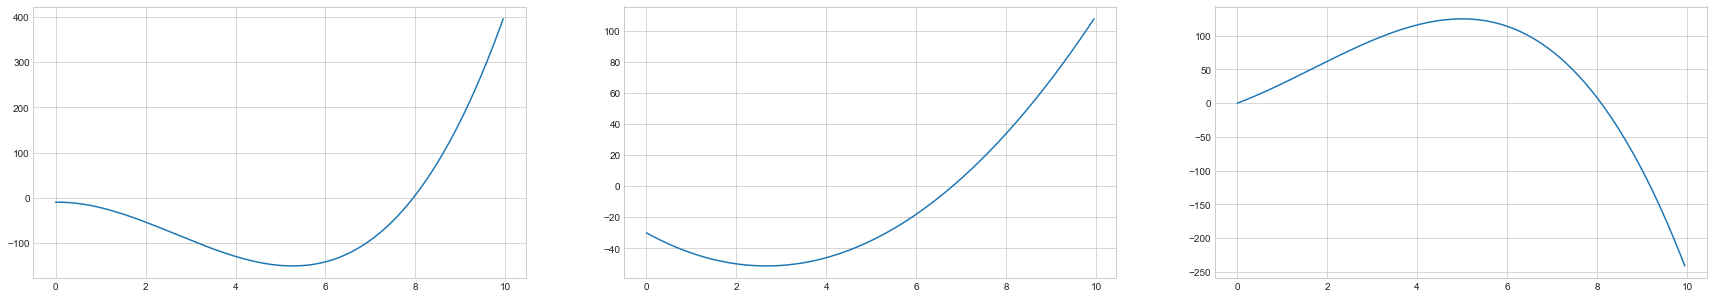

In [23]:
plot_data(input_, 3, target)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 4873840.603454525
0th additional RBFlayer 249th epoch MSE Loss: 85263.04098988338
0th additional RBFlayer 499th epoch MSE Loss: 54266.13658136564
0th additional RBFlayer 749th epoch MSE Loss: 43912.58979288604
0th additional RBFlayer 999th epoch MSE Loss: 38933.054759886734
0th additional RBFlayer 1249th epoch MSE Loss: 36066.913667482826
0th additional RBFlayer 1499th epoch MSE Loss: 34227.349487750515
0th additional RBFlayer 1749th epoch MSE Loss: 32956.571281374025
0th additional RBFlayer 1999th epoch MSE Loss: 32030.807024530255
0th additional RBFlayer 2249th epoch MSE Loss: 31328.67617900343
0th additional RBFlayer 2499th epoch MSE Loss: 30779.048303570657
0th additional RBFlayer 2749th epoch MSE Loss: 30337.6709131549
0th additional RBFlayer 2999th epoch MSE Loss: 29975.666979495472
0th additional RBFlayer best loss : 


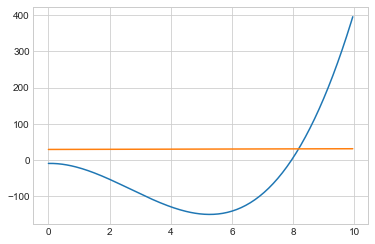

1th additional rbflayer
a: tensor([[ 365.3195,  351.5583,  338.0141,  324.6854,  311.5706,  298.6684,
          285.9772,  273.4954,  261.2216,  249.1544,  237.2921,  225.6333,
          214.1765,  202.9202,  191.8629,  181.0031, -180.8281, -180.8260,
         -180.7512, -180.7464]], device='cuda:0', dtype=torch.float64)
1th additional RBFlayer 0th epoch loss: 2852109.005451259
1th additional RBFlayer 249th epoch MSE Loss: 20014.450512507363
1th additional RBFlayer 499th epoch MSE Loss: 15180.168203968313
1th additional RBFlayer 749th epoch MSE Loss: 11344.620146059156
1th additional RBFlayer 999th epoch MSE Loss: 5871.166625021861
1th additional RBFlayer 1249th epoch MSE Loss: 6598.10665616025
1th additional RBFlayer 1499th epoch MSE Loss: 6197.933566852775
1th additional RBFlayer 1749th epoch MSE Loss: 24914.342967543398
1th additional RBFlayer 1999th epoch MSE Loss: 6314.54366909444
1th additional RBFlayer 2249th epoch MSE Loss: 12842.01420556848
1th additional RBFlayer 2499th epoch

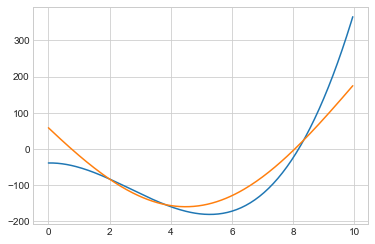

2th additional rbflayer
a: tensor([[190.6068, 181.7544, 173.1124, 164.6786, 156.4507, 148.4264, 140.6033,
         132.9792, 125.5518, 118.3187, 111.2777, 104.4264,  97.7624, -97.2470,
         -93.1971,  91.2835, -89.2390, -85.3718,  84.9873, -81.5948]],
       device='cuda:0', dtype=torch.float64)
2th additional RBFlayer 0th epoch loss: 605991.03831053
2th additional RBFlayer 249th epoch MSE Loss: 4477.500580810568
2th additional RBFlayer 499th epoch MSE Loss: 2872.788415863703
2th additional RBFlayer 749th epoch MSE Loss: 3027.7921015450997
2th additional RBFlayer 999th epoch MSE Loss: 3130.792349181
2th additional RBFlayer 1249th epoch MSE Loss: 3203.596496282285
2th additional RBFlayer 1499th epoch MSE Loss: 3252.2582965853708
2th additional RBFlayer 1749th epoch MSE Loss: 3258.21817107062
2th additional RBFlayer 1999th epoch MSE Loss: 3349.7590728798696
2th additional RBFlayer 2249th epoch MSE Loss: 3192.3834970197327
2th additional RBFlayer 2499th epoch MSE Loss: 3307.2282834642

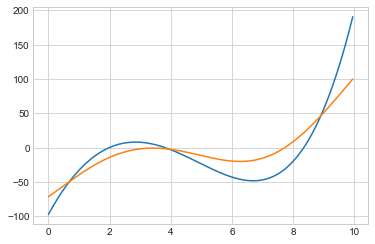

3th additional rbflayer
a: tensor([[ 90.6726,  84.4453,  78.4301,  72.6234,  67.0218,  61.6217,  56.4196,
          51.4118,  46.5947,  41.9647,  37.5180,  33.2510, -32.5549, -32.5512,
         -32.5190, -32.5057, -32.4456, -32.4160, -32.3370, -32.2797]],
       device='cuda:0', dtype=torch.float64)
3th additional RBFlayer 0th epoch loss: 59849.55614740668
3th additional RBFlayer 249th epoch MSE Loss: 193.5437650338885
3th additional RBFlayer 499th epoch MSE Loss: 149.5652531546728
3th additional RBFlayer 749th epoch MSE Loss: 131.7752171957309
3th additional RBFlayer 999th epoch MSE Loss: 122.2966676251693
3th additional RBFlayer 1249th epoch MSE Loss: 112.3900657332772
3th additional RBFlayer 1499th epoch MSE Loss: 110.10859942679132
3th additional RBFlayer 1749th epoch MSE Loss: 114.10457852712005
3th additional RBFlayer 1999th epoch MSE Loss: 112.30010948071758
3th additional RBFlayer 2249th epoch MSE Loss: 107.70124052053194
3th additional RBFlayer 2499th epoch MSE Loss: 104.49837

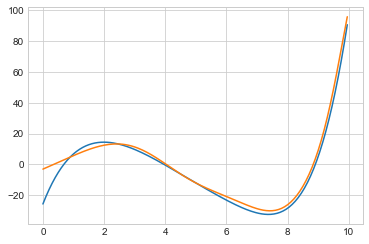

4th additional rbflayer
a: tensor([[-22.6534, -20.5881, -18.6321, -16.7826, -15.0368, -13.3919, -11.8449,
         -10.3932,  -9.0337,  -7.7638,  -7.6756,  -7.6224,  -7.5908,  -7.4617,
          -7.3350,  -7.2210,  -6.9248,  -6.8738,  -6.5941,  -6.5805]],
       device='cuda:0', dtype=torch.float64)
4th additional RBFlayer 0th epoch loss: 3523.273843914934
4th additional RBFlayer 249th epoch MSE Loss: 12.484512712578624
4th additional RBFlayer 499th epoch MSE Loss: 12.293752347904697
4th additional RBFlayer 749th epoch MSE Loss: 12.077094921786497
4th additional RBFlayer 999th epoch MSE Loss: 11.889674938927397
4th additional RBFlayer 1249th epoch MSE Loss: 12.115975686329003
4th additional RBFlayer 1499th epoch MSE Loss: 12.243235602244981
4th additional RBFlayer 1749th epoch MSE Loss: 12.304700363260078
4th additional RBFlayer 1999th epoch MSE Loss: 12.330149994127284
4th additional RBFlayer 2249th epoch MSE Loss: 12.223074202996415
4th additional RBFlayer 2499th epoch MSE Loss: 12.3

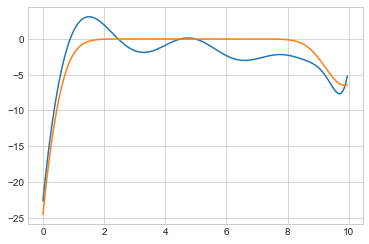

5th additional rbflayer
a: tensor([[ 3.5428,  3.5423,  3.5251,  3.5244,  3.4899,  3.4889,  3.4400,  3.4341,
          3.3763,  3.3608,  3.3006,  3.2696,  3.2147,  3.1609,  3.1208,  3.0356,
          3.0214, -3.0030, -2.9993, -2.9979]], device='cuda:0',
       dtype=torch.float64)
5th additional RBFlayer 0th epoch loss: 1689.7211261167542
5th additional RBFlayer 249th epoch MSE Loss: 12.699142222652197
5th additional RBFlayer 499th epoch MSE Loss: 9.494325194319467
5th additional RBFlayer 749th epoch MSE Loss: 8.687260789054708
5th additional RBFlayer 999th epoch MSE Loss: 8.349807696947082
5th additional RBFlayer 1249th epoch MSE Loss: 8.180938917663568
5th additional RBFlayer 1499th epoch MSE Loss: 8.089415726890362
5th additional RBFlayer 1749th epoch MSE Loss: 8.037327897321648
5th additional RBFlayer 1999th epoch MSE Loss: 8.006483376133243
5th additional RBFlayer 2249th epoch MSE Loss: 7.987463131590881
5th additional RBFlayer 2499th epoch MSE Loss: 7.975158065937426
5th additiona

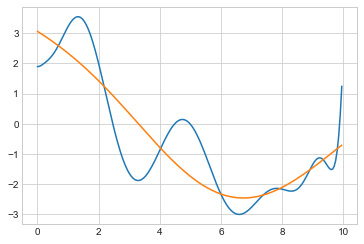

6th additional rbflayer
a: tensor([[-2.0050, -1.9998, -1.9955, -1.9799, -1.9715,  1.9529, -1.9454, -1.9332,
         -1.8966, -1.8809, -1.8337, -1.8151, -1.7572,  1.7414,  1.7398, -1.7364,
          1.7306,  1.7260,  1.7072,  1.7004]], device='cuda:0',
       dtype=torch.float64)
6th additional RBFlayer 0th epoch loss: 169.6319364002912
6th additional RBFlayer 249th epoch MSE Loss: 8.419542974282708
6th additional RBFlayer 499th epoch MSE Loss: 8.153939563815534
6th additional RBFlayer 749th epoch MSE Loss: 8.02106190167832
6th additional RBFlayer 999th epoch MSE Loss: 7.956357174832527
6th additional RBFlayer 1249th epoch MSE Loss: 7.925577660440756
6th additional RBFlayer 1499th epoch MSE Loss: 7.907577391975699
6th additional RBFlayer 1749th epoch MSE Loss: 7.895643502314741
6th additional RBFlayer 1999th epoch MSE Loss: 7.8871667186453225
6th additional RBFlayer 2249th epoch MSE Loss: 7.880866334502869
6th additional RBFlayer 2499th epoch MSE Loss: 7.876011836420507
6th additional 

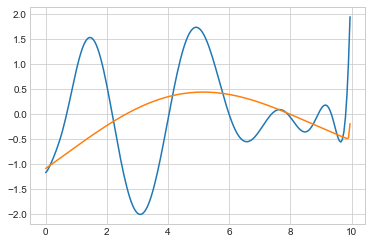

7th additional rbflayer
a: tensor([[-2.1594, -2.1549, -2.1490,  2.1398, -2.1355, -2.1240, -2.1011, -2.0848,
         -2.0518, -2.0317,  2.0009,  1.9957,  1.9883, -1.9878,  1.9728, -1.9653,
          1.9577,  1.9331, -1.9096,  1.9093]], device='cuda:0',
       dtype=torch.float64)
7th additional RBFlayer 0th epoch loss: 319.107188069879
7th additional RBFlayer 249th epoch MSE Loss: 5.4560925777442195
7th additional RBFlayer 499th epoch MSE Loss: 5.069433722294788
7th additional RBFlayer 749th epoch MSE Loss: 4.58956102487253
7th additional RBFlayer 999th epoch MSE Loss: 3.8305316398670115
7th additional RBFlayer 1249th epoch MSE Loss: 4.136620733076935
7th additional RBFlayer 1499th epoch MSE Loss: 3.8742855387802986
7th additional RBFlayer 1749th epoch MSE Loss: 3.769725558869146
7th additional RBFlayer 1999th epoch MSE Loss: 3.6599613414111714
7th additional RBFlayer 2249th epoch MSE Loss: 3.528247954279953
7th additional RBFlayer 2499th epoch MSE Loss: 3.378665000281968
7th additiona

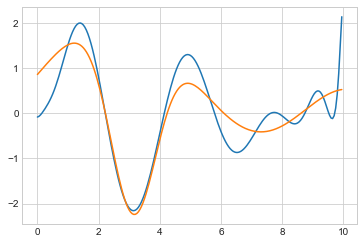

In [28]:
model = MultiRBFnn2(single_target.size(0), 20, device)
model.train(input_, single_target, 3000, 0.00001, 5, 10)

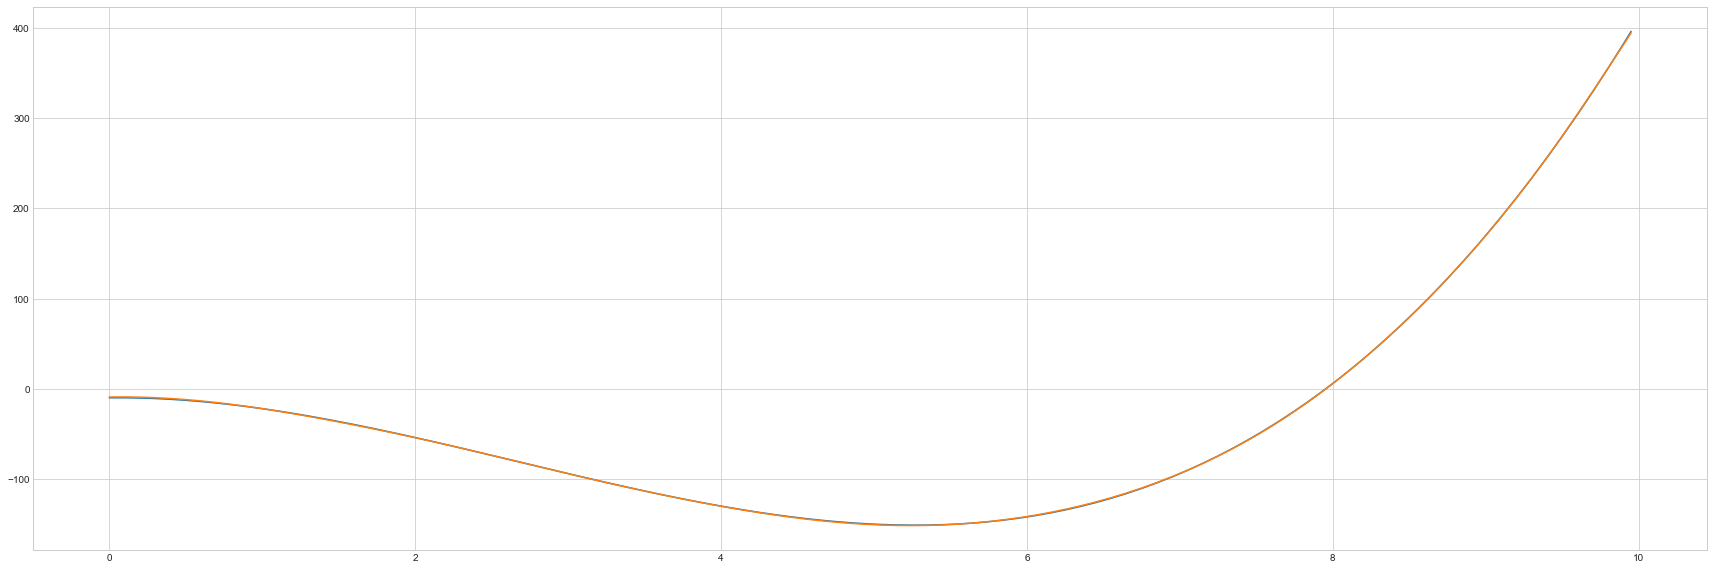

In [29]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

In [32]:
single_target2 = torch.tensor(np.array(y2), device = device, dtype=float).reshape(1,200)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 521404.15086368594
0th additional RBFlayer 249th epoch MSE Loss: 2562.1510912353087
0th additional RBFlayer 499th epoch MSE Loss: 2287.718460573642
0th additional RBFlayer 749th epoch MSE Loss: 2068.1225819227225
0th additional RBFlayer 999th epoch MSE Loss: 1321.9189049314448
0th additional RBFlayer 1249th epoch MSE Loss: 1470.9815997291255
0th additional RBFlayer 1499th epoch MSE Loss: 1455.5044218750368
0th additional RBFlayer 1749th epoch MSE Loss: 1443.0870950118458
0th additional RBFlayer 1999th epoch MSE Loss: 1430.6011957861062
0th additional RBFlayer 2249th epoch MSE Loss: 1417.5846002218673
0th additional RBFlayer 2499th epoch MSE Loss: 1403.7529311151882
0th additional RBFlayer 2749th epoch MSE Loss: 1388.8146560249975
0th additional RBFlayer 2999th epoch MSE Loss: 1372.3884830697225
0th additional RBFlayer best loss : 


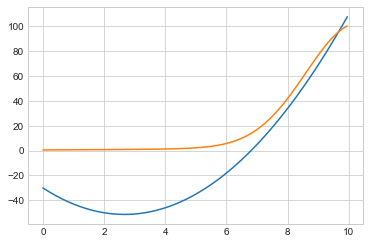

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 378016.6901919682
1th additional RBFlayer 249th epoch MSE Loss: 51.66146977821378
1th additional RBFlayer 499th epoch MSE Loss: 45.04580459099189
1th additional RBFlayer 749th epoch MSE Loss: 41.45296834632539
1th additional RBFlayer 999th epoch MSE Loss: 39.43083331559139
1th additional RBFlayer 1249th epoch MSE Loss: 38.264991500054926
1th additional RBFlayer 1499th epoch MSE Loss: 37.57704587257791
1th additional RBFlayer 1749th epoch MSE Loss: 37.16129644072031
1th additional RBFlayer 1999th epoch MSE Loss: 36.90373177148578
1th additional RBFlayer 2249th epoch MSE Loss: 36.740044605161806
1th additional RBFlayer 2499th epoch MSE Loss: 36.63332479598792
1th additional RBFlayer 2749th epoch MSE Loss: 36.561993807754625
1th additional RBFlayer 2999th epoch MSE Loss: 36.513183127996356
1th additional RBFlayer best loss : 


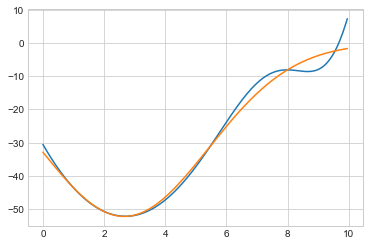

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 1549.287883989358
2th additional RBFlayer 249th epoch MSE Loss: 47.851600581411006
2th additional RBFlayer 499th epoch MSE Loss: 37.149387742400194
2th additional RBFlayer 749th epoch MSE Loss: 36.718415734838615
2th additional RBFlayer 999th epoch MSE Loss: 30.419630634071595
2th additional RBFlayer 1249th epoch MSE Loss: 27.52282953641319
2th additional RBFlayer 1499th epoch MSE Loss: 25.07542849854176
2th additional RBFlayer 1749th epoch MSE Loss: 22.519700471325
2th additional RBFlayer 1999th epoch MSE Loss: 19.654194870642737
2th additional RBFlayer 2249th epoch MSE Loss: 28.521005044088092
2th additional RBFlayer 2499th epoch MSE Loss: 27.69091374874275
2th additional RBFlayer 2749th epoch MSE Loss: 27.492630010735983
2th additional RBFlayer 2999th epoch MSE Loss: 27.63943387207775
2th additional RBFlayer best loss : 


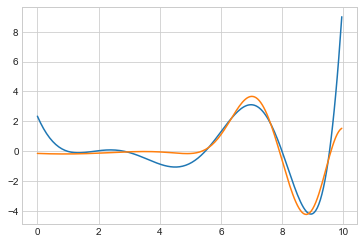

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 151.07329472868017
3th additional RBFlayer 249th epoch MSE Loss: 1.6859903672611012
3th additional RBFlayer 499th epoch MSE Loss: 1.0994758448761108
3th additional RBFlayer 749th epoch MSE Loss: 1.019477030870819
3th additional RBFlayer 999th epoch MSE Loss: 0.9997320091075449
3th additional RBFlayer 1249th epoch MSE Loss: 0.990530609930465
3th additional RBFlayer 1499th epoch MSE Loss: 0.9849166008881544
3th additional RBFlayer 1749th epoch MSE Loss: 0.9808380536345701
3th additional RBFlayer 1999th epoch MSE Loss: 0.9774274593283887
3th additional RBFlayer 2249th epoch MSE Loss: 0.9742414521196591
3th additional RBFlayer 2499th epoch MSE Loss: 0.9710224911821109
3th additional RBFlayer 2749th epoch MSE Loss: 0.9676061997021984
3th additional RBFlayer 2999th epoch MSE Loss: 0.963888410249595
3th additional RBFlayer best loss : 
change lr  0.0001
----------------------------------------------
change round number 6
--------

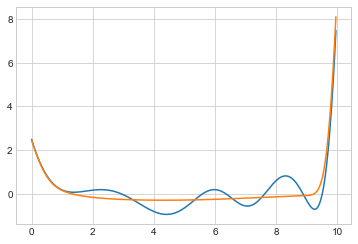

In [33]:
model2 = MultiRBFnn2(single_target2.size(0), 20, device)
model2.train(input_, single_target2, 3000, 0.00001, 5, 10)

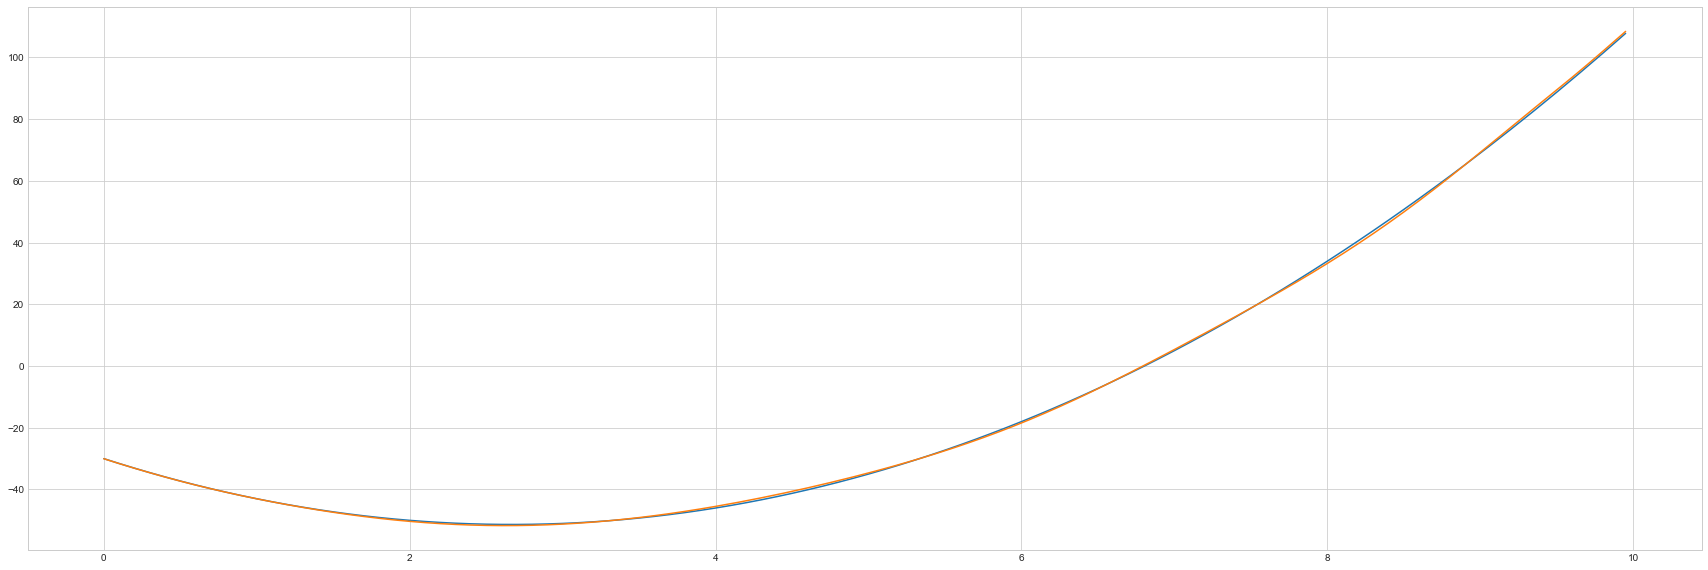

In [34]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model2.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 1314077.0358547347
0th additional RBFlayer 249th epoch MSE Loss: 9595.118136509644
0th additional RBFlayer 499th epoch MSE Loss: 9344.916177143676
0th additional RBFlayer 749th epoch MSE Loss: 9196.997828253912
0th additional RBFlayer 999th epoch MSE Loss: 9086.163368816158
0th additional RBFlayer 1249th epoch MSE Loss: 8966.0113914319
0th additional RBFlayer 1499th epoch MSE Loss: 8687.417922694993
0th additional RBFlayer 1749th epoch MSE Loss: 9211.010229761407
0th additional RBFlayer 1999th epoch MSE Loss: 9322.226499878301
0th additional RBFlayer 2249th epoch MSE Loss: 6255.309644759316
0th additional RBFlayer 2499th epoch MSE Loss: 8596.006393854392
0th additional RBFlayer 2749th epoch MSE Loss: 9022.437317954318
0th additional RBFlayer 2999th epoch MSE Loss: 2009.0902151031764
0th additional RBFlayer best loss : 1933.3281754308287


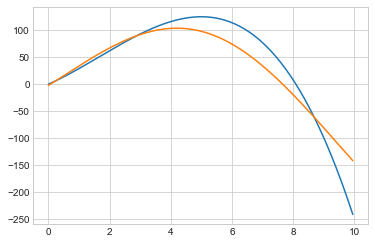

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 104083.29606674906
1th additional RBFlayer 249th epoch MSE Loss: 24.162909737305004
1th additional RBFlayer 499th epoch MSE Loss: 15.222569602918998
1th additional RBFlayer 749th epoch MSE Loss: 33.11304200373091
1th additional RBFlayer 999th epoch MSE Loss: 11.426625363761435
1th additional RBFlayer 1249th epoch MSE Loss: 14.204552384734388
1th additional RBFlayer 1499th epoch MSE Loss: 13.12800235959257
1th additional RBFlayer 1749th epoch MSE Loss: 9.88769063636532
1th additional RBFlayer 1999th epoch MSE Loss: 7.580910309015865
1th additional RBFlayer 2249th epoch MSE Loss: 7.073243205392738
1th additional RBFlayer 2499th epoch MSE Loss: 6.625562538464181
1th additional RBFlayer 2749th epoch MSE Loss: 6.23152805906255
1th additional RBFlayer 2999th epoch MSE Loss: 5.905166831109027
1th additional RBFlayer best loss : 5.904016912621759
change lr  0.0001
----------------------------------------------


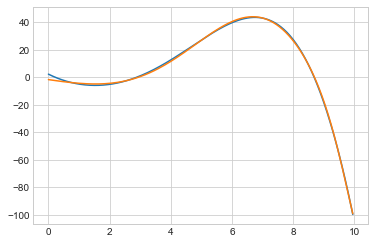

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 196.76952745460414
2th additional RBFlayer 249th epoch MSE Loss: 2.8608205297107436
2th additional RBFlayer 499th epoch MSE Loss: 2.8171851208433525
2th additional RBFlayer 749th epoch MSE Loss: 2.7801758831222845
2th additional RBFlayer 999th epoch MSE Loss: 2.743860677536003
2th additional RBFlayer 1249th epoch MSE Loss: 2.7068711591278696
2th additional RBFlayer 1499th epoch MSE Loss: 2.6696885365636747
2th additional RBFlayer 1749th epoch MSE Loss: 2.6349535172106586
2th additional RBFlayer 1999th epoch MSE Loss: 2.6053361006258116
2th additional RBFlayer 2249th epoch MSE Loss: 2.5805653278084675
2th additional RBFlayer 2499th epoch MSE Loss: 2.5576252363257304
2th additional RBFlayer 2749th epoch MSE Loss: 2.538992303519032
2th additional RBFlayer 2999th epoch MSE Loss: 2.525666833581622
2th additional RBFlayer best loss : 2.525616821006295
change round number 6
----------------------------------------------


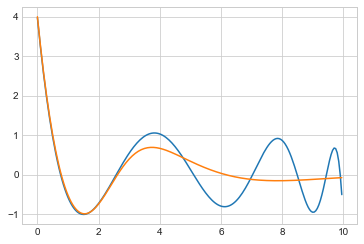

In [36]:
single_target3 = torch.tensor(np.array(y3), device = device, dtype=float).reshape(1,200)
model3 = MultiRBFnn2(single_target3.size(0), 20, device)
model3.train(input_, single_target3, 3000, 0.00001, 5, 10)

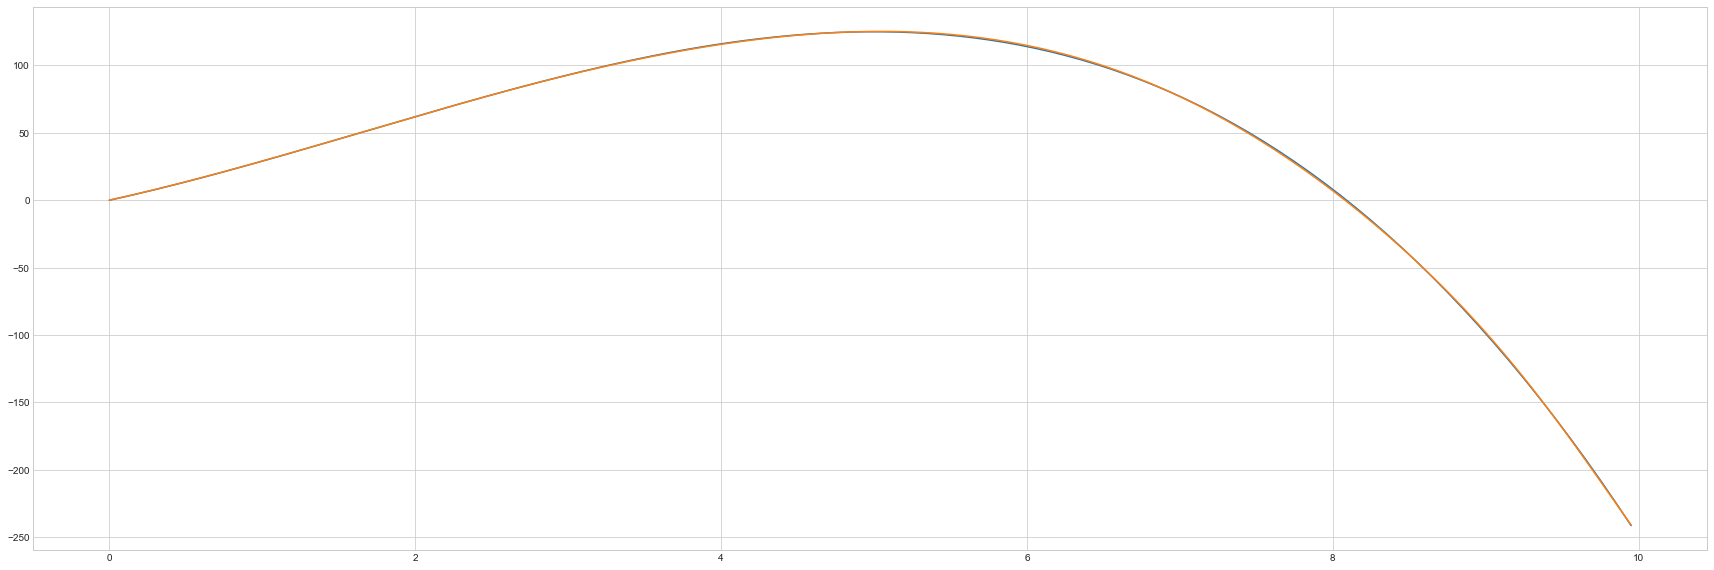

In [37]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target3[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model3.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 2268606.6509954412
0th additional RBFlayer 249th epoch MSE Loss: 57903.65117169084
0th additional RBFlayer 499th epoch MSE Loss: 39926.64174145554
0th additional RBFlayer 749th epoch MSE Loss: 34579.43434607546
0th additional RBFlayer 999th epoch MSE Loss: 32174.374258756117
0th additional RBFlayer 1249th epoch MSE Loss: 30851.797004727578
0th additional RBFlayer 1499th epoch MSE Loss: 30031.50690967927
0th additional RBFlayer 1749th epoch MSE Loss: 29480.223921845427
0th additional RBFlayer 1999th epoch MSE Loss: 29087.85847989988
0th additional RBFlayer 2249th epoch MSE Loss: 28796.332030567693
0th additional RBFlayer 2499th epoch MSE Loss: 28572.373589958308
0th additional RBFlayer 2749th epoch MSE Loss: 28395.673522856694
0th additional RBFlayer 2999th epoch MSE Loss: 28253.19173315704
0th additional RBFlayer best loss : 28253.19173315704


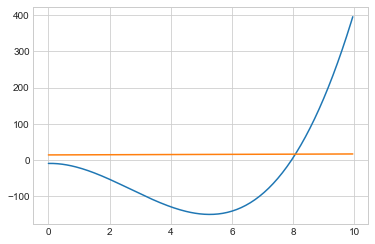

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 3712286.340277236
1th additional RBFlayer 249th epoch MSE Loss: 22996.91016921077
1th additional RBFlayer 499th epoch MSE Loss: 22253.779318306297
1th additional RBFlayer 749th epoch MSE Loss: 21667.676751896415
1th additional RBFlayer 999th epoch MSE Loss: 21059.166309084976
1th additional RBFlayer 1249th epoch MSE Loss: 20333.60346818146
1th additional RBFlayer 1499th epoch MSE Loss: 13498.569864499905
1th additional RBFlayer 1749th epoch MSE Loss: 10702.252304674228
1th additional RBFlayer 1999th epoch MSE Loss: 10052.429326526362
1th additional RBFlayer 2249th epoch MSE Loss: 7393.818540626915
1th additional RBFlayer 2499th epoch MSE Loss: 7367.3583674270285
1th additional RBFlayer 2749th epoch MSE Loss: 7203.995185516605
1th additional RBFlayer 2999th epoch MSE Loss: 11283.105215876712
1th additional RBFlayer best loss : 6945.0375005366795


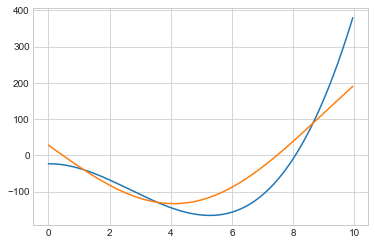

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 424775.5218473246
2th additional RBFlayer 249th epoch MSE Loss: 5365.583552290202
2th additional RBFlayer 499th epoch MSE Loss: 3244.388276242121
2th additional RBFlayer 749th epoch MSE Loss: 3210.073609757359
2th additional RBFlayer 999th epoch MSE Loss: 3174.524746416031
2th additional RBFlayer 1249th epoch MSE Loss: 3088.4247795903466
2th additional RBFlayer 1499th epoch MSE Loss: 3020.472881812412
2th additional RBFlayer 1749th epoch MSE Loss: 2974.613869457339
2th additional RBFlayer 1999th epoch MSE Loss: 2942.1793471430788
2th additional RBFlayer 2249th epoch MSE Loss: 2921.340952533419
2th additional RBFlayer 2499th epoch MSE Loss: 2916.3982454296165
2th additional RBFlayer 2749th epoch MSE Loss: 2951.467409737056
2th additional RBFlayer 2999th epoch MSE Loss: 2947.487371356312
2th additional RBFlayer best loss : 1040.1277344567984


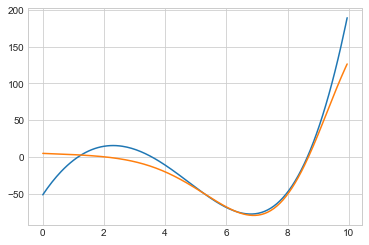

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 51953.18406259339
3th additional RBFlayer 249th epoch MSE Loss: 101.4608316370699
3th additional RBFlayer 499th epoch MSE Loss: 98.17809011029831
3th additional RBFlayer 749th epoch MSE Loss: 100.0871496977947
3th additional RBFlayer 999th epoch MSE Loss: 106.04292435529307
3th additional RBFlayer 1249th epoch MSE Loss: 105.08194477278123
3th additional RBFlayer 1499th epoch MSE Loss: 104.52182429572677
3th additional RBFlayer 1749th epoch MSE Loss: 104.4490596039805
3th additional RBFlayer 1999th epoch MSE Loss: 104.26233861927372
3th additional RBFlayer 2249th epoch MSE Loss: 104.08851764151346
3th additional RBFlayer 2499th epoch MSE Loss: 103.95201814119473
3th additional RBFlayer 2749th epoch MSE Loss: 101.02879903611542
3th additional RBFlayer 2999th epoch MSE Loss: 104.12860471593478
3th additional RBFlayer best loss : 98.11312532741373


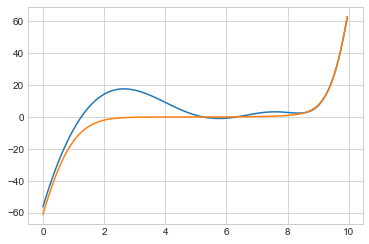

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 84719.03282303523
4th additional RBFlayer 249th epoch MSE Loss: 60.609298793648534
4th additional RBFlayer 499th epoch MSE Loss: 47.32398825855277
4th additional RBFlayer 749th epoch MSE Loss: 45.52884144285709
4th additional RBFlayer 999th epoch MSE Loss: 44.73663364863458
4th additional RBFlayer 1249th epoch MSE Loss: 43.908980811403524
4th additional RBFlayer 1499th epoch MSE Loss: 42.8575716920431
4th additional RBFlayer 1749th epoch MSE Loss: 41.37178300566444
4th additional RBFlayer 1999th epoch MSE Loss: 39.001013905301775
4th additional RBFlayer 2249th epoch MSE Loss: 34.49371821816619
4th additional RBFlayer 2499th epoch MSE Loss: 24.396800289579723
4th additional RBFlayer 2749th epoch MSE Loss: 15.26679009077508
4th additional RBFlayer 2999th epoch MSE Loss: 13.014909906252798
4th additional RBFlayer best loss : 13.014909906252798


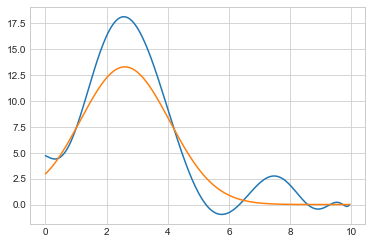

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 8326.759817921858
5th additional RBFlayer 249th epoch MSE Loss: 12.198108830254013
5th additional RBFlayer 499th epoch MSE Loss: 12.198039473684954
5th additional RBFlayer 749th epoch MSE Loss: 12.197982505040791
5th additional RBFlayer 999th epoch MSE Loss: 12.197925567966616
5th additional RBFlayer 1249th epoch MSE Loss: 12.197868662298951
5th additional RBFlayer 1499th epoch MSE Loss: 12.197811787874583
5th additional RBFlayer 1749th epoch MSE Loss: 12.197754944530498
5th additional RBFlayer 1999th epoch MSE Loss: 12.197698132103922
5th additional RBFlayer 2249th epoch MSE Loss: 12.197641350432296
5th additional RBFlayer 2499th epoch MSE Loss: 12.197584599353279
5th additional RBFlayer 2749th epoch MSE Loss: 12.197527878704753
5th additional RBFlayer 2999th epoch MSE Loss: 12.197471188324814
5th additional RBFlayer best loss : 12.197471188324814


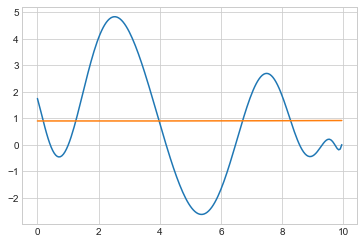

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 2179.0894694229246
6th additional RBFlayer 249th epoch MSE Loss: 12.109545169108191
6th additional RBFlayer 499th epoch MSE Loss: 12.10894051611001
6th additional RBFlayer 749th epoch MSE Loss: 12.108340042822562
6th additional RBFlayer 999th epoch MSE Loss: 12.107740493307224
6th additional RBFlayer 1249th epoch MSE Loss: 12.107141865089105
6th additional RBFlayer 1499th epoch MSE Loss: 12.106544155710859
6th additional RBFlayer 1749th epoch MSE Loss: 12.105947362732664
6th additional RBFlayer 1999th epoch MSE Loss: 12.105351483732141
6th additional RBFlayer 2249th epoch MSE Loss: 12.104756516304215
6th additional RBFlayer 2499th epoch MSE Loss: 12.104162458061024
6th additional RBFlayer 2749th epoch MSE Loss: 12.103569306631812
6th additional RBFlayer 2999th epoch MSE Loss: 12.102977059662829
6th additional RBFlayer best loss : 12.102977059662829


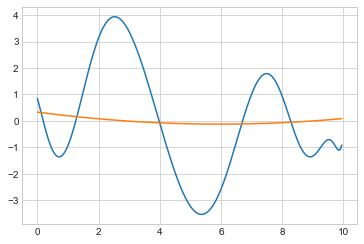

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 2846.3138234090547
7th additional RBFlayer 249th epoch MSE Loss: 12.08692234603806
7th additional RBFlayer 499th epoch MSE Loss: 12.083609904771242
7th additional RBFlayer 749th epoch MSE Loss: 12.080391816724127
7th additional RBFlayer 999th epoch MSE Loss: 12.077259849907804
7th additional RBFlayer 1249th epoch MSE Loss: 12.074211429523706
7th additional RBFlayer 1499th epoch MSE Loss: 12.071244062833074
7th additional RBFlayer 1749th epoch MSE Loss: 12.06835533620082
7th additional RBFlayer 1999th epoch MSE Loss: 12.065542912268521
7th additional RBFlayer 2249th epoch MSE Loss: 12.062804527249357
7th additional RBFlayer 2499th epoch MSE Loss: 12.060137988338658
7th additional RBFlayer 2749th epoch MSE Loss: 12.057541171233897
7th additional RBFlayer 2999th epoch MSE Loss: 12.055012017758523
7th additional RBFlayer best loss : 12.055012017758523


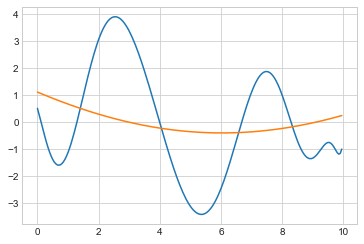

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 3342.386552804768
8th additional RBFlayer 249th epoch MSE Loss: 11.927562214770791
8th additional RBFlayer 499th epoch MSE Loss: 11.906707953958843
8th additional RBFlayer 749th epoch MSE Loss: 11.897262779466692
8th additional RBFlayer 999th epoch MSE Loss: 11.888188765573087
8th additional RBFlayer 1249th epoch MSE Loss: 11.879468380052195
8th additional RBFlayer 1499th epoch MSE Loss: 11.871085592142254
8th additional RBFlayer 1749th epoch MSE Loss: 11.863025640058677
8th additional RBFlayer 1999th epoch MSE Loss: 11.855274872948614
8th additional RBFlayer 2249th epoch MSE Loss: 11.847820612339838
8th additional RBFlayer 2499th epoch MSE Loss: 11.84065103069686
8th additional RBFlayer 2749th epoch MSE Loss: 11.833755045066557
8th additional RBFlayer 2999th epoch MSE Loss: 11.827122224081561
8th additional RBFlayer best loss : 11.827122224081561


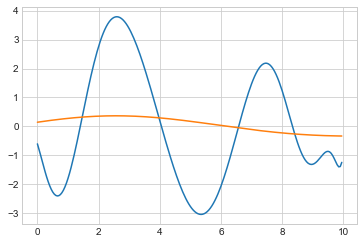

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 652.1805805158258
9th additional RBFlayer 249th epoch MSE Loss: 12.182166538979619
9th additional RBFlayer 499th epoch MSE Loss: 9.759615419524273
9th additional RBFlayer 749th epoch MSE Loss: 8.366090422232507
9th additional RBFlayer 999th epoch MSE Loss: 6.910988689081193
9th additional RBFlayer 1249th epoch MSE Loss: 5.603758689408369
9th additional RBFlayer 1499th epoch MSE Loss: 4.6655998019120455
9th additional RBFlayer 1749th epoch MSE Loss: 4.095652607952866
9th additional RBFlayer 1999th epoch MSE Loss: 3.7777711065808877
9th additional RBFlayer 2249th epoch MSE Loss: 3.6041162497928396
9th additional RBFlayer 2499th epoch MSE Loss: 3.506107215433774
9th additional RBFlayer 2749th epoch MSE Loss: 3.446087053967284
9th additional RBFlayer 2999th epoch MSE Loss: 3.40496646297485
9th additional RBFlayer best loss : 3.40496646297485
change lr  0.01
----------------------------------------------
change round number 6
-

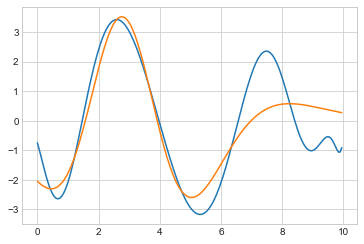

In [41]:
model = MultiRBFnn2(single_target.size(0), 20, device)
model.train(input_, single_target, 3000, 0.001, 5, 10)

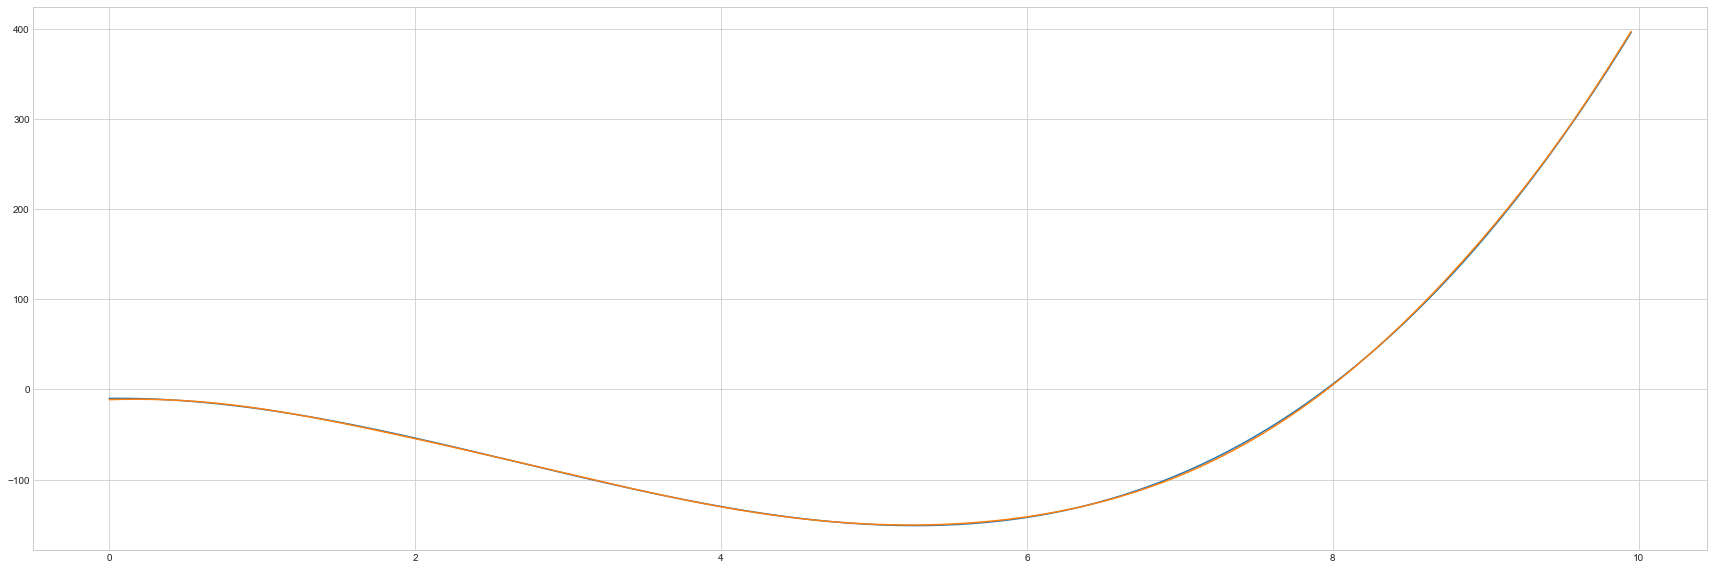

In [42]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model.pred(input_)[1][0].cpu().detach().numpy())
plt.show()